# Description
Data are taken from [UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

The goal is to build and compare several regression models to obtain stable results. The comparison includes models such as:
- Linear Regression
- Support Vector Machines
- Decision Trees
- Random Forest
- Extreme Trees
- Adaptive Boosting
- Gradient Boosting 
- XGBoost
Data 


## Importing libraries and prepering dataset

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import metrics

from sklearn.svm import SVR
import xgboost as xgb 
from sklearn.linear_model import LinearRegression

In [99]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [100]:
In [27]: df=df.rename(columns = {'model year':'model_year', 'car name': 'car_name'})

In [101]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

In [102]:
df.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [103]:
df.shape

(398, 9)

In [104]:
df = df[df.horsepower != '?']

In [105]:
df['horsepower'] = df['horsepower'].astype('float')

In [106]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

In [108]:
df['diesel'] = (df['car_name'].str.contains('diesel')).astype(int)

In [109]:
df.loc[df['diesel']==1]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,diesel
244,43.1,4,90.0,48.0,1985,21.5,78,2,volkswagen rabbit custom diesel,1
325,44.3,4,90.0,48.0,2085,21.7,80,2,vw rabbit c (diesel),1
326,43.4,4,90.0,48.0,2335,23.7,80,2,vw dasher (diesel),1
327,36.4,5,121.0,67.0,2950,19.9,80,2,audi 5000s (diesel),1
359,28.1,4,141.0,80.0,3230,20.4,81,2,peugeot 505s turbo diesel,1
360,30.7,6,145.0,76.0,3160,19.6,81,2,volvo diesel,1
387,38.0,6,262.0,85.0,3015,17.0,82,1,oldsmobile cutlass ciera (diesel),1


In [110]:
labels = df['mpg']
features = df.drop('mpg', axis=1)

In [112]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,diesel
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0


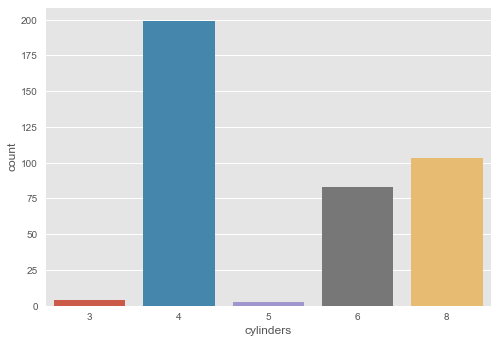

In [310]:
sns.countplot(df['cylinders'])
plt.savefig('cylinders')
plt.show()

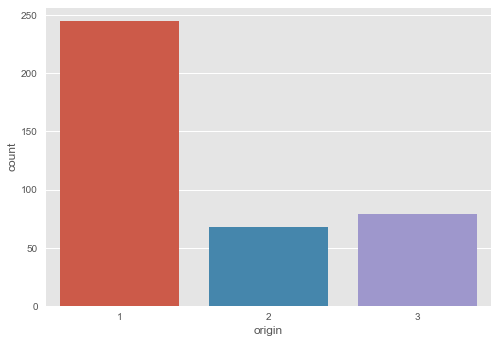

In [311]:
sns.countplot(df['origin'])
plt.savefig('origin')
plt.show()

Relations between features.

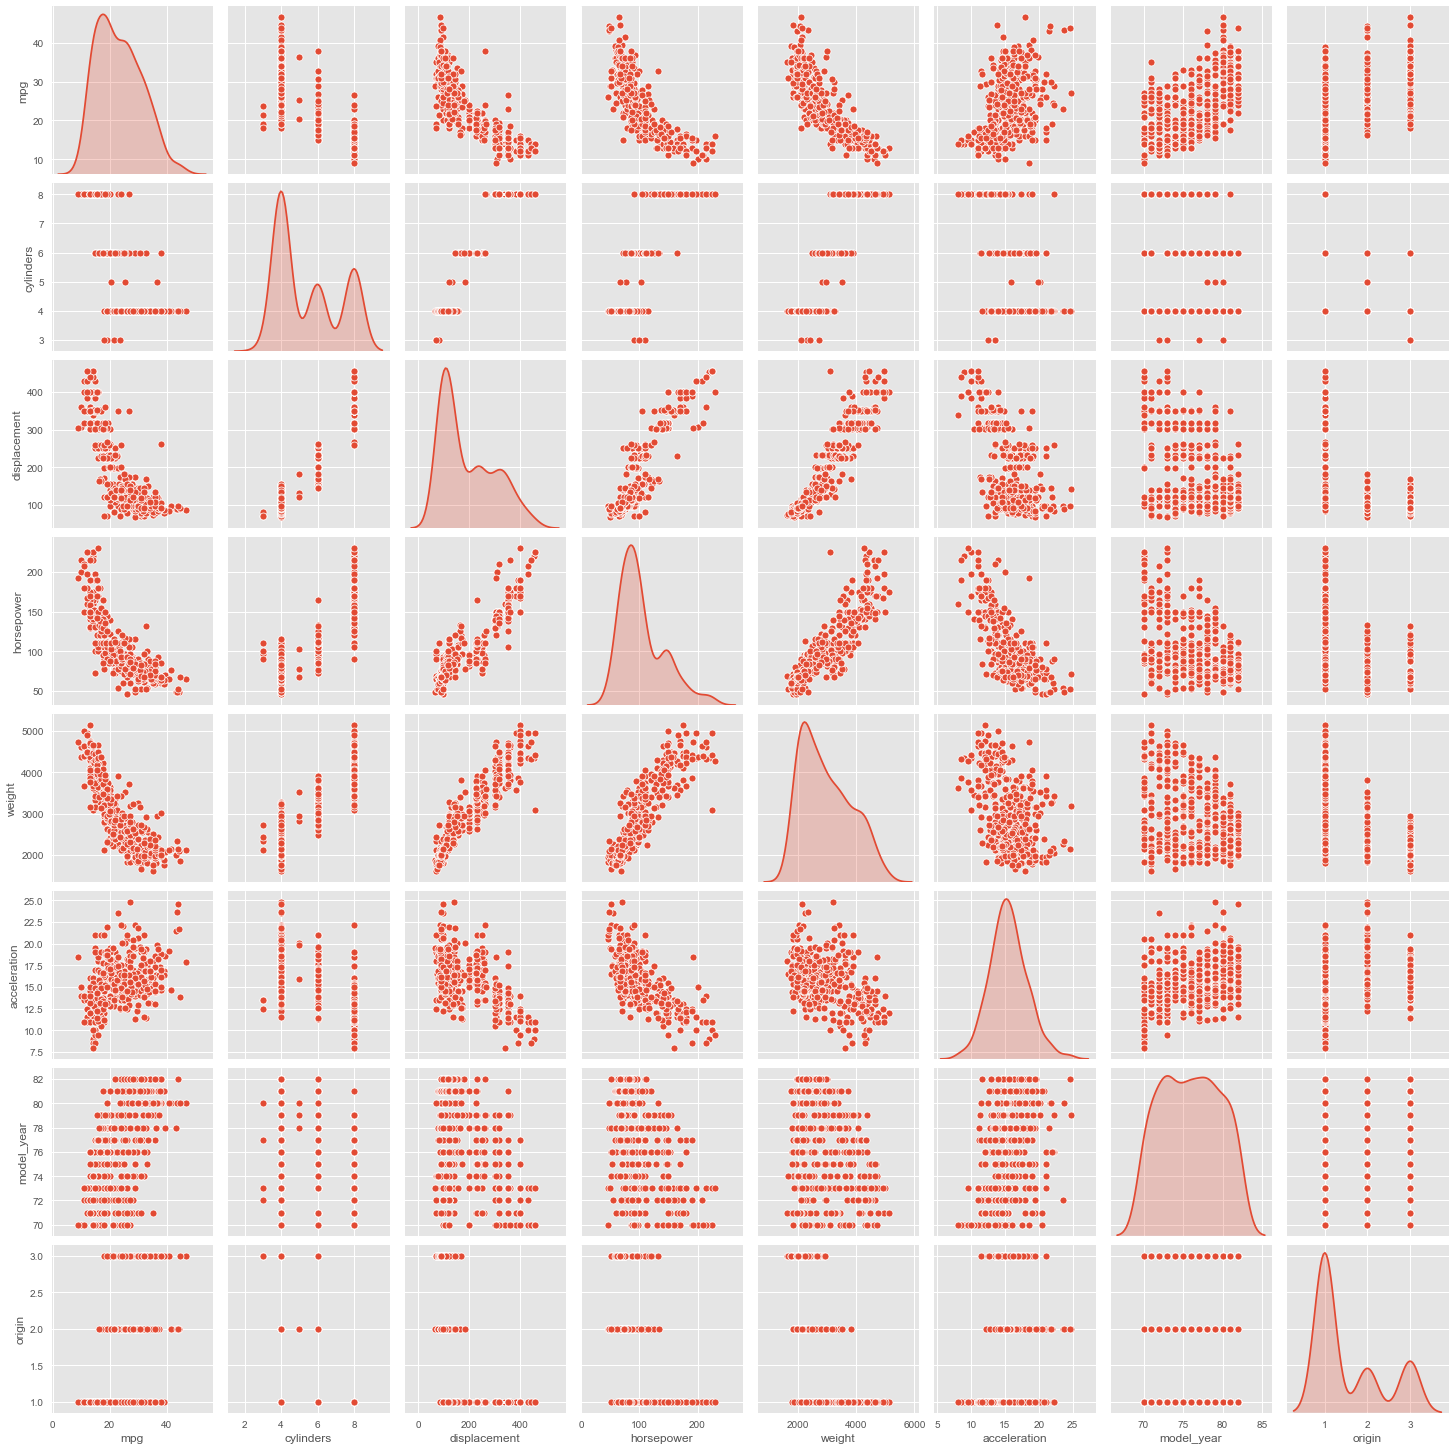

In [261]:
sns.pairplot(df.drop(['car_name', 'diesel'], axis=1 ) , diag_kind="kde")
plt.savefig('pairplot.png')
plt.show()

There is a significant relation between mpg and and displacement, horsepower, weight. We can look at Pearson's correlation to be sure.

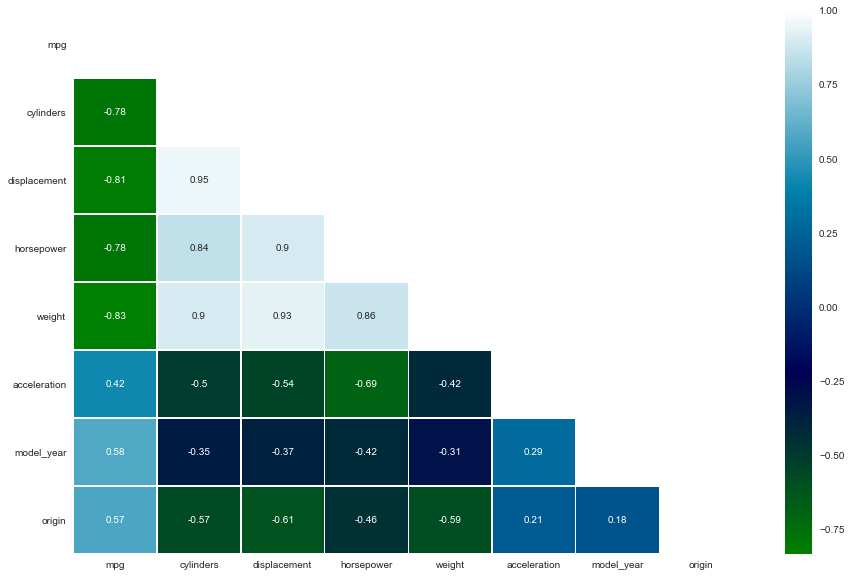

In [309]:
corr = df.drop(['car_name', 'diesel'], axis=1 ).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, mask=mask, annot=True, linewidth=0.5, cmap='ocean')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
plt.savefig('heatmap.png')
plt.show()

## Data division and modeling.

In [128]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.25, random_state=42)

In [129]:
X_train_outcar = X_train.drop(['car_name'], axis=1)
X_test_outcar = X_test.drop(['car_name'], axis=1)

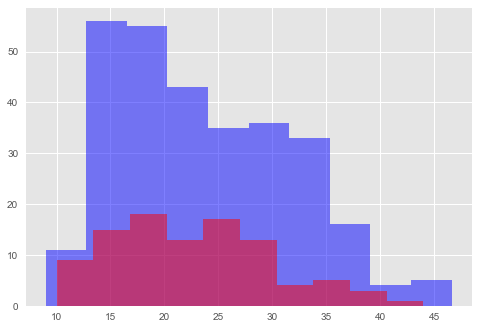

In [242]:
plt.hist(y_train, color='blue', alpha=0.5)
plt.hist(y_test, color='red', alpha=0.5)
plt.show()

In [134]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['displacement', 'horsepower', 'weight', 'acceleration', 'model_year'])),
    ])

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["cylinders", 'origin', 'diesel'])),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [135]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [312]:
pipe1 = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scale', StandardScaler()),
    ('regressor', LinearRegression(n_jobs=-1))
])

param1 = {
    'scale' : [StandardScaler(), None]
}

grid_1 = GridSearchCV(pipe1, param_grid=param1, cv=kfold, n_jobs=-1)

grid_1.fit(X_train_outcar, y_train)
print(grid_1.best_params_)

{'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [137]:
pipe2 = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scale', StandardScaler()),
    ('regressor', SVR(kernel='rbf'))
])

param2 = {
    'scale' : [StandardScaler(), None],
    'regressor__C' : [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'regressor__gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 1, 100, 1000]
}

grid_2 = GridSearchCV(pipe2, param_grid=param2, cv=kfold, n_jobs=-1)

grid_2.fit(X_train_outcar, y_train)
print(grid_2.best_params_)

{'regressor__C': 100, 'regressor__gamma': 0.01, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [138]:
pipe3 = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scale', StandardScaler()),
    ('regressor', DecisionTreeRegressor())
])

param3 = {
    'scale' : [StandardScaler(), None],
    'regressor__criterion' : ['mse', 'mea'],
    'regressor__max_depth' : [3,4,5,8,10,15,20,25],
    'regressor__max_leaf_nodes':[5,7,10,15],
    'regressor__min_samples_leaf':[2,3,5,8,10,15,20]
}

grid_3 = GridSearchCV(pipe3, param_grid=param3, cv=kfold, n_jobs=-1)

grid_3.fit(X_train_outcar, y_train)
print(grid_3.best_params_)

{'regressor__criterion': 'mse', 'regressor__max_depth': 4, 'regressor__max_leaf_nodes': 15, 'regressor__min_samples_leaf': 8, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [139]:
pipe4 = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scale', StandardScaler()),
    ('regresor', ExtraTreeRegressor())
])

param4 = {
    'scale' : [StandardScaler(), None],
    'regresor__criterion' : ['mse', 'mea'],
    'regresor__max_depth' : [3,4,5,8,10,15,20,25],
    'regresor__max_leaf_nodes':[5,7,10,15],
    'regresor__min_samples_leaf':[2,3,5,8,10,15,20]
}

grid_4 = GridSearchCV(pipe4, param_grid=param4, cv=kfold, n_jobs=-1)

grid_4.fit(X_train_outcar, y_train)
print(grid_4.best_params_)

{'regresor__criterion': 'mse', 'regresor__max_depth': 20, 'regresor__max_leaf_nodes': 15, 'regresor__min_samples_leaf': 8, 'scale': None}


In [140]:
pipe5 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('scale', StandardScaler()),
    ('regressor', RandomForestRegressor(criterion='mse'))])

param5 = {
    'scale' : [StandardScaler(), None],
    'regressor__n_estimators': [50,100,150,200,250],
    'regressor__max_leaf_nodes':[2,5,10,15],
    'regressor__max_depth':[3,5,10,None]
}

grid_5= GridSearchCV(pipe5, param5, cv=kfold)

grid_5.fit(X_train_outcar, y_train)

print(grid_5.best_params_)

{'regressor__max_depth': 5, 'regressor__max_leaf_nodes': 15, 'regressor__n_estimators': 100, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [141]:
pipe6= Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('scale', StandardScaler()),
    ('regressor', AdaBoostRegressor(DecisionTreeRegressor(criterion='mse',
                                                        max_depth=4,
                                                        max_leaf_nodes=15,
                                                        min_samples_leaf=8))
    )
])

param6 ={
        'scale' : [StandardScaler(), None],
        'regressor__n_estimators' : [1,5,10,25,50,70,80,100],
        'regressor__learning_rate' : [0.25,0.5,0.75,1, 1.25],
        'regressor__loss': ['linear', 'square']
}

grid_6=GridSearchCV(pipe6, param6, cv=kfold)

grid_6.fit(X_train_outcar, y_train)
print(grid_6.best_params_)

{'regressor__learning_rate': 1.25, 'regressor__loss': 'square', 'regressor__n_estimators': 100, 'scale': None}


In [142]:
pipe7= Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('scale', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])

param7 ={
        'scale' : [StandardScaler(), None],
        'regressor__n_estimators': [1,5,10,50,80,100,120,150],
        'regressor__learning_rate':[0.1,0.5,0.75,1]}

grid_7=GridSearchCV(pipe7, param7, cv=kfold)

grid_7.fit(X_train_outcar, y_train)
print(grid_7.best_params_)

{'regressor__learning_rate': 0.1, 'regressor__n_estimators': 150, 'scale': None}


In [143]:
pipe8= Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('scale', StandardScaler()),
    ('regressor', xgboost.XGBRegressor(n_jobs=-1))
])

param8 ={
    'scale' : [StandardScaler(), None],
    'regressor__n_estimators': [1,3,5,10,15,50],
    'regressor__gamma': [1,3,5,7],
    'regressor__min_child_weight': [10,15,50,100],
    'regressor__reg_alpha': [0.5,1,2],
    'regressor__reg_lambda': [0.5,1,1.5],
    'regressor__learning_rate':[0.5,0.75,1]
}

grid_8 = GridSearchCV(pipe8, param8, cv=kfold)

grid_8.fit(X_train_outcar, y_train)
print(grid_8.best_params_)

{'regressor__gamma': 7, 'regressor__learning_rate': 0.5, 'regressor__min_child_weight': 15, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 1, 'regressor__reg_lambda': 0.5, 'scale': None}


In [145]:
pipe9 = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scale', StandardScaler()),
    ('regressor', xgb.XGBRegressor(n_jobs=-1))
])

param9 = {
    'scale' : [StandardScaler(), None],
    'regressor__max_depth': randint(3, 11),
    'regressor__learning_rate': uniform(0.001, 0.1-0.001),
    'regressor__n_estimators': randint(50, 400),
    'regressor__gamma': uniform(0,2),
    'regressor__colsample_bytree': uniform(0.5, 0.5),
    'regressor__subsample': uniform(0.5, 0.5),
    'regressor__min_child_weight': randint(1, 11)}

grid_9 = RandomizedSearchCV(n_iter=30,
                             estimator=pipe9,
                             param_distributions=param9,
                             cv=kfold)

grid_9.fit(X_train_outcar, y_train)
print(grid_9.best_params_)

{'regressor__colsample_bytree': 0.7113194128323184, 'regressor__gamma': 1.9907333364755844, 'regressor__learning_rate': 0.07767020900187722, 'regressor__max_depth': 7, 'regressor__min_child_weight': 2, 'regressor__n_estimators': 197, 'regressor__subsample': 0.5523195282936155, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [314]:
models = []
models.append(('Linear Regression', grid_1.best_estimator_))
models.append(('SVR rbf', grid_2.best_estimator_))
models.append(('Decision Tree', grid_3.best_estimator_))
models.append(('Random Forest', grid_4.best_estimator_))
models.append(('Extreme Trees', grid_5.best_estimator_))
models.append(('AdaBoost', grid_6.best_estimator_))
models.append(('GradientBoost', grid_7.best_estimator_))
models.append(('XGBoost', grid_8.best_estimator_))
models.append(('Random XGBoost', grid_9.best_estimator_))

r2 = []
mae = []
mse = []

for name, model in models:   
    mae.append( metrics.mean_absolute_error(y_test , model.predict(X_test_outcar)) )
    mse.append( metrics.mean_squared_error(y_test , model.predict(X_test_outcar)) )
    r2.append( metrics.r2_score(y_test , model.predict(X_test_outcar)) )

Summary table.

In [315]:
dictionary = {
    'mean absolute error' : mae,
    'mean squared error': mse,
    'r2_score': r2_score
}
table = pd.DataFrame(dictionary)
table.insert(loc=0, column='Method', value=['Linear Regression',
                                         'SVR rbf',
                                         'Decision Tree',
                                         'Random Forest',
                                         'Extreme Trees', 
                                         'AdaBoost',
                                         'GradientBoost',
                                         'XGBoost',
                                         'Random XGBoost'])
table.to_csv('results.csv')
table.sort_values('r2_score', ascending=False)

,Method,mean absolute error,mean squared error,r2_score
1,SVR rbf,1.677495,5.410333,0.892723
6,GradientBoost,1.759057,6.227173,0.876526
4,Extreme Trees,1.903730,6.300586,0.875070
8,Random XGBoost,1.699143,6.324814,0.874590
7,XGBoost,1.857661,6.675127,0.867644
5,AdaBoost,1.945314,7.698350,0.847355
0,Linear Regression,2.089396,7.963950,0.842089
2,Decision Tree,2.239329,8.689641,0.827700
3,Random Forest,2.298387,9.812184,0.805442


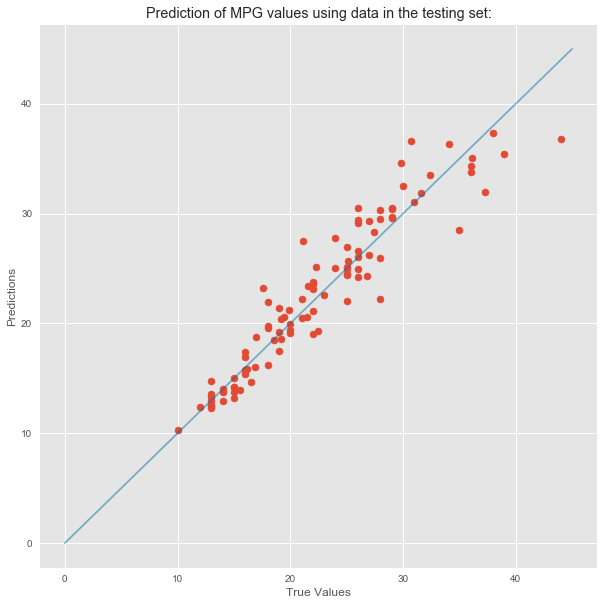

In [308]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, grid_2.predict(X_test_outcar))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([0, 45], [0, 45], 'b', alpha=0.5)
plt.title('Prediction of MPG values using data in the testing set:')
plt.savefig('predictions')
plt.show()

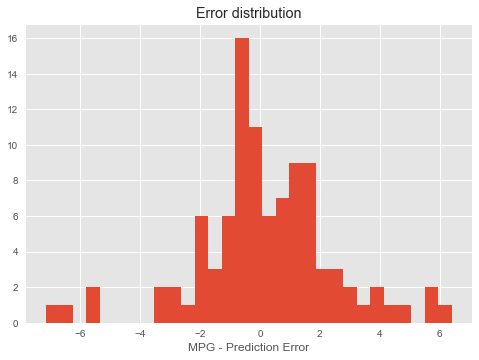

In [301]:
plt.hist(grid_2.predict(X_test_outcar)- y_test, bins=30)
plt.title('Error distribution')
plt.xlabel('MPG - Prediction Error')
plt.savefig('model_error')
plt.show()

Examples of mpg predictions using the SVR model

In [303]:
results = pd.DataFrame({'car name': X_test['car_name'], 
                        'label mpg': y_test, 
                        'prediction': grid_2.predict(X_test_outcar)})
results.head(10)

,car name,label mpg,prediction
79,renault 12 (sw),26.0,26.009262
276,saab 99gle,21.6,23.402332
248,honda civic cvcc,36.1,35.038622
56,plymouth cricket,26.0,24.251110
393,ford mustang gl,27.0,29.296472
205,toyota corolla,28.0,30.349962
43,ford country squire (sw),13.0,12.315371
235,toyota corolla liftback,26.0,30.538779
152,plymouth valiant custom,19.0,19.255705
117,fiat 128,29.0,30.521879
